In [287]:
import sqlite3
import pandas as pd
import datetime
import cpi
import seaborn as sns
import matplotlib.pyplot as plt

conn = sqlite3.connect('data\im.db')

In [288]:
df = pd.read_sql_query("SELECT name FROM sqlite_master WHERE type='table';", conn)
table_names = df['name'].values

movie_basics = pd.read_sql_query("SELECT * FROM movie_basics", conn)
directors = pd.read_sql_query("SELECT * FROM directors", conn)
known_for = pd.read_sql_query("SELECT * FROM known_for", conn)
movie_akas = pd.read_sql_query("SELECT * FROM movie_akas", conn)
movie_ratings = pd.read_sql_query("SELECT * FROM movie_ratings", conn)
persons = pd.read_sql_query("SELECT * FROM persons", conn)
principals = pd.read_sql_query("SELECT * FROM principals", conn)
writers = pd.read_sql_query("SELECT * FROM writers", conn)


In [289]:
info = pd.read_csv("data/rt.movie_info.tsv", sep='\t',header=0, encoding='ISO-8859-1')
reviews = pd.read_csv("data/rt.reviews.tsv", sep='\t',header=0, encoding='ISO-8859-1')
gross = pd.read_csv("data/bom.movie_gross.csv",header=0, encoding='ISO-8859-1') 
movies = pd.read_csv("data/tmdb.movies.csv",header=0, encoding='ISO-8859-1') 
budget = pd.read_csv("data/tn.movie_budgets.csv",header=0, encoding='ISO-8859-1') 


In [290]:
gross['foreign_gross'] = gross['foreign_gross'].fillna(0)
gross['foreign_gross'] = pd.to_numeric(gross['foreign_gross'], errors='coerce')
gross['gross'] = gross['foreign_gross'] + gross['domestic_gross']

In [291]:
info

,id,synopsis,rating,genre,director,writer,theater_date,dvd_date,currency,box_office,runtime,studio
0,1,"This gritty, fast-paced, and innovative police...",R,Action and Adventure|Classics|Drama,William Friedkin,Ernest Tidyman,"Oct 9, 1971","Sep 25, 2001",NaN,NaN,104 minutes,NaN
1,3,"New York City, not-too-distant-future: Eric Pa...",R,Drama|Science Fiction and Fantasy,David Cronenberg,David Cronenberg|Don DeLillo,"Aug 17, 2012","Jan 1, 2013",$,"600,000",108 minutes,Entertainment One
2,5,Illeana Douglas delivers a superb performance ...,R,Drama|Musical and Performing Arts,Allison Anders,Allison Anders,"Sep 13, 1996","Apr 18, 2000",NaN,NaN,116 minutes,NaN
3,6,Michael Douglas runs afoul of a treacherous su...,R,Drama|Mystery and Suspense,Barry Levinson,Paul Attanasio|Michael Crichton,"Dec 9, 1994","Aug 27, 1997",NaN,NaN,128 minutes,NaN
4,7,NaN,NR,Drama|Romance,Rodney Bennett,Giles Cooper,NaN,NaN,NaN,NaN,200 minutes,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
1555,1996,Forget terrorists or hijackers -- there's a ha...,R,Action and Adventure|Horror|Mystery and Suspense,NaN,NaN,"Aug 18, 2006","Jan 2, 2007",$,"33,886,034",106 minutes,New Line Cinema
1556,1997,The popular Saturday Night Live sketch was exp...,PG,Comedy|Science Fiction and Fantasy,Steve Barron,Terry Turner|Tom Davis|Dan Aykroyd|Bonnie Turner,"Jul 23, 1993","Apr 17, 2001",NaN,NaN,88 minutes,Paramount Vantage
1557,1998,"Based on a novel by Richard Powell, when the l...",G,Classics|Comedy|Drama|Musical and Performing Arts,Gordon Douglas,NaN,"Jan 1, 1962","May 11, 2004",NaN,NaN,111 minutes,NaN
1558,1999,The Sandlot is a coming-of-age story about a g...,PG,Comedy|Drama|Kids and Family|Sports and Fitness,David Mickey Evans,David Mickey Evans|Robert Gunter,"Apr 1, 1993","Jan 29, 2002",NaN,NaN,101 minutes,NaN


In [292]:
movie_basics[movie_basics['original_title'] == 'Eden']

,movie_id,primary_title,original_title,start_year,runtime_minutes,genres
4717,tt10429158,Eden,Eden,2020,NaN,Drama
15289,tt1734433,Eden,Eden,2012,98.0,"Crime,Drama"
26733,tt2063641,Eden,Eden,2012,101.0,"Comedy,Drama"
29548,tt2132321,Eden,Eden,2016,71.0,Drama
51163,tt3032282,Eden,Eden,2014,90.0,"Drama,Thriller"
52109,tt3090634,Eden,Eden,2014,131.0,"Biography,Drama,Music"
102185,tt5975878,Eden,Eden,2015,90.0,Animation
124123,tt7539088,Eden,Eden,2019,85.0,"Crime,Drama"
141016,tt9174880,Eden,Eden,2018,97.0,Drama


In [293]:
movies

,Unnamed: 0,genre_ids,id,original_language,original_title,popularity,release_date,title,vote_average,vote_count
0,0,"[12, 14, 10751]",12444,en,Harry Potter and the Deathly Hallows: Part 1,33.533,2010-11-19,Harry Potter and the Deathly Hallows: Part 1,7.7,10788
1,1,"[14, 12, 16, 10751]",10191,en,How to Train Your Dragon,28.734,2010-03-26,How to Train Your Dragon,7.7,7610
2,2,"[12, 28, 878]",10138,en,Iron Man 2,28.515,2010-05-07,Iron Man 2,6.8,12368
3,3,"[16, 35, 10751]",862,en,Toy Story,28.005,1995-11-22,Toy Story,7.9,10174
4,4,"[28, 878, 12]",27205,en,Inception,27.920,2010-07-16,Inception,8.3,22186
...,...,...,...,...,...,...,...,...,...,...
26512,26512,"[27, 18]",488143,en,Laboratory Conditions,0.600,2018-10-13,Laboratory Conditions,0.0,1
26513,26513,"[18, 53]",485975,en,_EXHIBIT_84xxx_,0.600,2018-05-01,_EXHIBIT_84xxx_,0.0,1
26514,26514,"[14, 28, 12]",381231,en,The Last One,0.600,2018-10-01,The Last One,0.0,1
26515,26515,"[10751, 12, 28]",366854,en,Trailer Made,0.600,2018-06-22,Trailer Made,0.0,1


In [294]:
# create new column in first dataframe that extracts the year from release_date
movies['theater_date'] = pd.to_datetime(movies['release_date']).dt.year

# merge the two dataframes on original_title and theater_date
merged_movies = pd.merge(movies, movie_basics, left_on=['original_title', 'theater_date'], right_on=['original_title', 'start_year'])

In [295]:
merged_movies = merged_movies.drop_duplicates(subset='title', keep=False)

In [296]:
merged_movies

,Unnamed: 0,genre_ids,id,original_language,original_title,popularity,release_date,title,vote_average,vote_count,theater_date,movie_id,primary_title,start_year,runtime_minutes,genres
0,0,"[12, 14, 10751]",12444,en,Harry Potter and the Deathly Hallows: Part 1,33.533,2010-11-19,Harry Potter and the Deathly Hallows: Part 1,7.7,10788,2010,tt0926084,Harry Potter and the Deathly Hallows: Part 1,2010,146.0,"Adventure,Fantasy,Mystery"
1,1,"[14, 12, 16, 10751]",10191,en,How to Train Your Dragon,28.734,2010-03-26,How to Train Your Dragon,7.7,7610,2010,tt0892769,How to Train Your Dragon,2010,98.0,"Action,Adventure,Animation"
2,2,"[12, 28, 878]",10138,en,Iron Man 2,28.515,2010-05-07,Iron Man 2,6.8,12368,2010,tt1228705,Iron Man 2,2010,124.0,"Action,Adventure,Sci-Fi"
3,4,"[28, 878, 12]",27205,en,Inception,27.920,2010-07-16,Inception,8.3,22186,2010,tt1375666,Inception,2010,148.0,"Action,Adventure,Sci-Fi"
4,5,"[12, 14, 10751]",32657,en,Percy Jackson & the Olympians: The Lightning T...,26.691,2010-02-11,Percy Jackson & the Olympians: The Lightning T...,6.1,4229,2010,tt0814255,Percy Jackson & the Olympians: The Lightning T...,2010,118.0,"Adventure,Family,Fantasy"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12185,26503,[99],543481,de,Evolution 4K,0.600,2018-06-12,Evolution 4K,1.0,1,2018,tt8267112,Evolution 4K,2018,56.0,Documentary
12187,26507,[99],545555,ar,Dreamaway,0.600,2018-10-14,Dream Away,0.0,2,2018,tt8917792,Dreamaway,2018,86.0,"Documentary,Fantasy"
12188,26509,[27],502255,en,Closing Time,0.600,2018-02-24,Closing Time,0.0,1,2018,tt8731118,Closing Time,2018,116.0,Documentary
12189,26514,"[14, 28, 12]",381231,en,The Last One,0.600,2018-10-01,The Last One,0.0,1,2018,tt3118968,The Last One,2018,85.0,"Action,Adventure,Fantasy"


In [297]:
gross

,title,studio,domestic_gross,foreign_gross,year,gross
0,Toy Story 3,BV,415000000.0,652000000.0,2010,1.067000e+09
1,Alice in Wonderland (2010),BV,334200000.0,691300000.0,2010,1.025500e+09
2,Harry Potter and the Deathly Hallows Part 1,WB,296000000.0,664300000.0,2010,9.603000e+08
3,Inception,WB,292600000.0,535700000.0,2010,8.283000e+08
4,Shrek Forever After,P/DW,238700000.0,513900000.0,2010,7.526000e+08
...,...,...,...,...,...,...
3382,The Quake,Magn.,6200.0,0.0,2018,6.200000e+03
3383,Edward II (2018 re-release),FM,4800.0,0.0,2018,4.800000e+03
3384,El Pacto,Sony,2500.0,0.0,2018,2.500000e+03
3385,The Swan,Synergetic,2400.0,0.0,2018,2.400000e+03


In [298]:
movies_gross = pd.merge(merged_movies, budget, left_on='title', right_on='movie')

In [299]:
movies_gross['worldwide_gross_int'] = movies_gross['worldwide_gross'].apply(lambda x: int(x.replace(",", "").replace("$", "")))
movies_gross['production_budget_int'] = movies_gross['production_budget'].apply(lambda x: int(x.replace(",", "").replace("$", "")))

In [300]:
movies_gross['profit'] =  (movies_gross['worldwide_gross_int'] - movies_gross['production_budget_int'])

In [301]:
movies_gross['release_date_x'] = pd.to_datetime(movies_gross['release_date_x'])

In [302]:
movies_gross['profit_adjusted'] = movies_gross.apply(lambda row: cpi.inflate(row['profit'],row['release_date_x'].year), axis=1)

In [311]:
movies_gross = movies_gross.dropna(subset=['genres'])

In [312]:
movies_gross = movies_gross.explode('genres')
genre_df = movies_gross.groupby('genres').size().reset_index(name='count')

#add the sum of profit_adjusted for each genre
genre_df = genre_df.join(movies_gross.groupby('genres')['profit_adjusted'].sum(),on='genres')


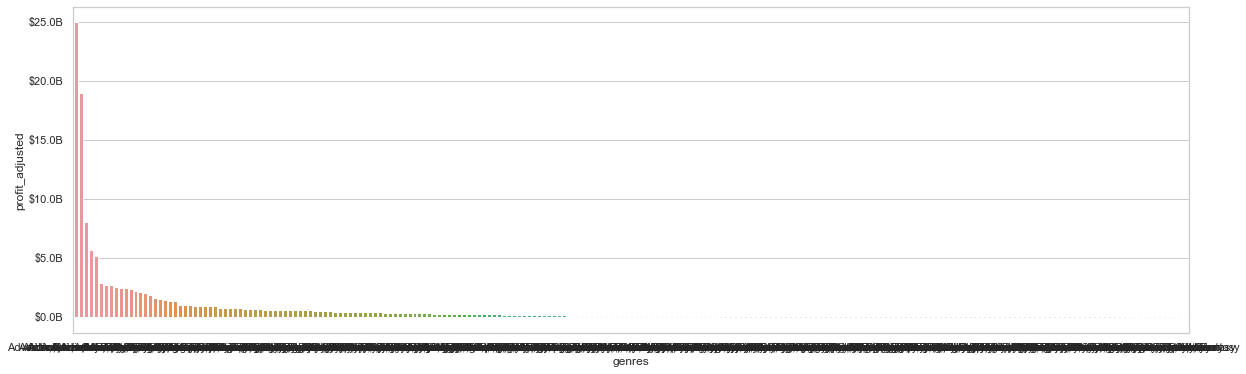

In [308]:
genre_df = genre_df.sort_values(by='profit_adjusted',ascending=False)
fig, ax = plt.subplots(figsize=(20,6))
sns.barplot(x='genres', y='profit_adjusted', data=genre_df, ax=ax)

def millions(x, pos):
    'The two args are the value and tick position'
    return '$%1.1fB' % (x * 1e-9)

formatter = ticker.FuncFormatter(millions)
ax.yaxis.set_major_formatter(formatter)

<AxesSubplot:xlabel='theater_date', ylabel='profit_adjusted'>

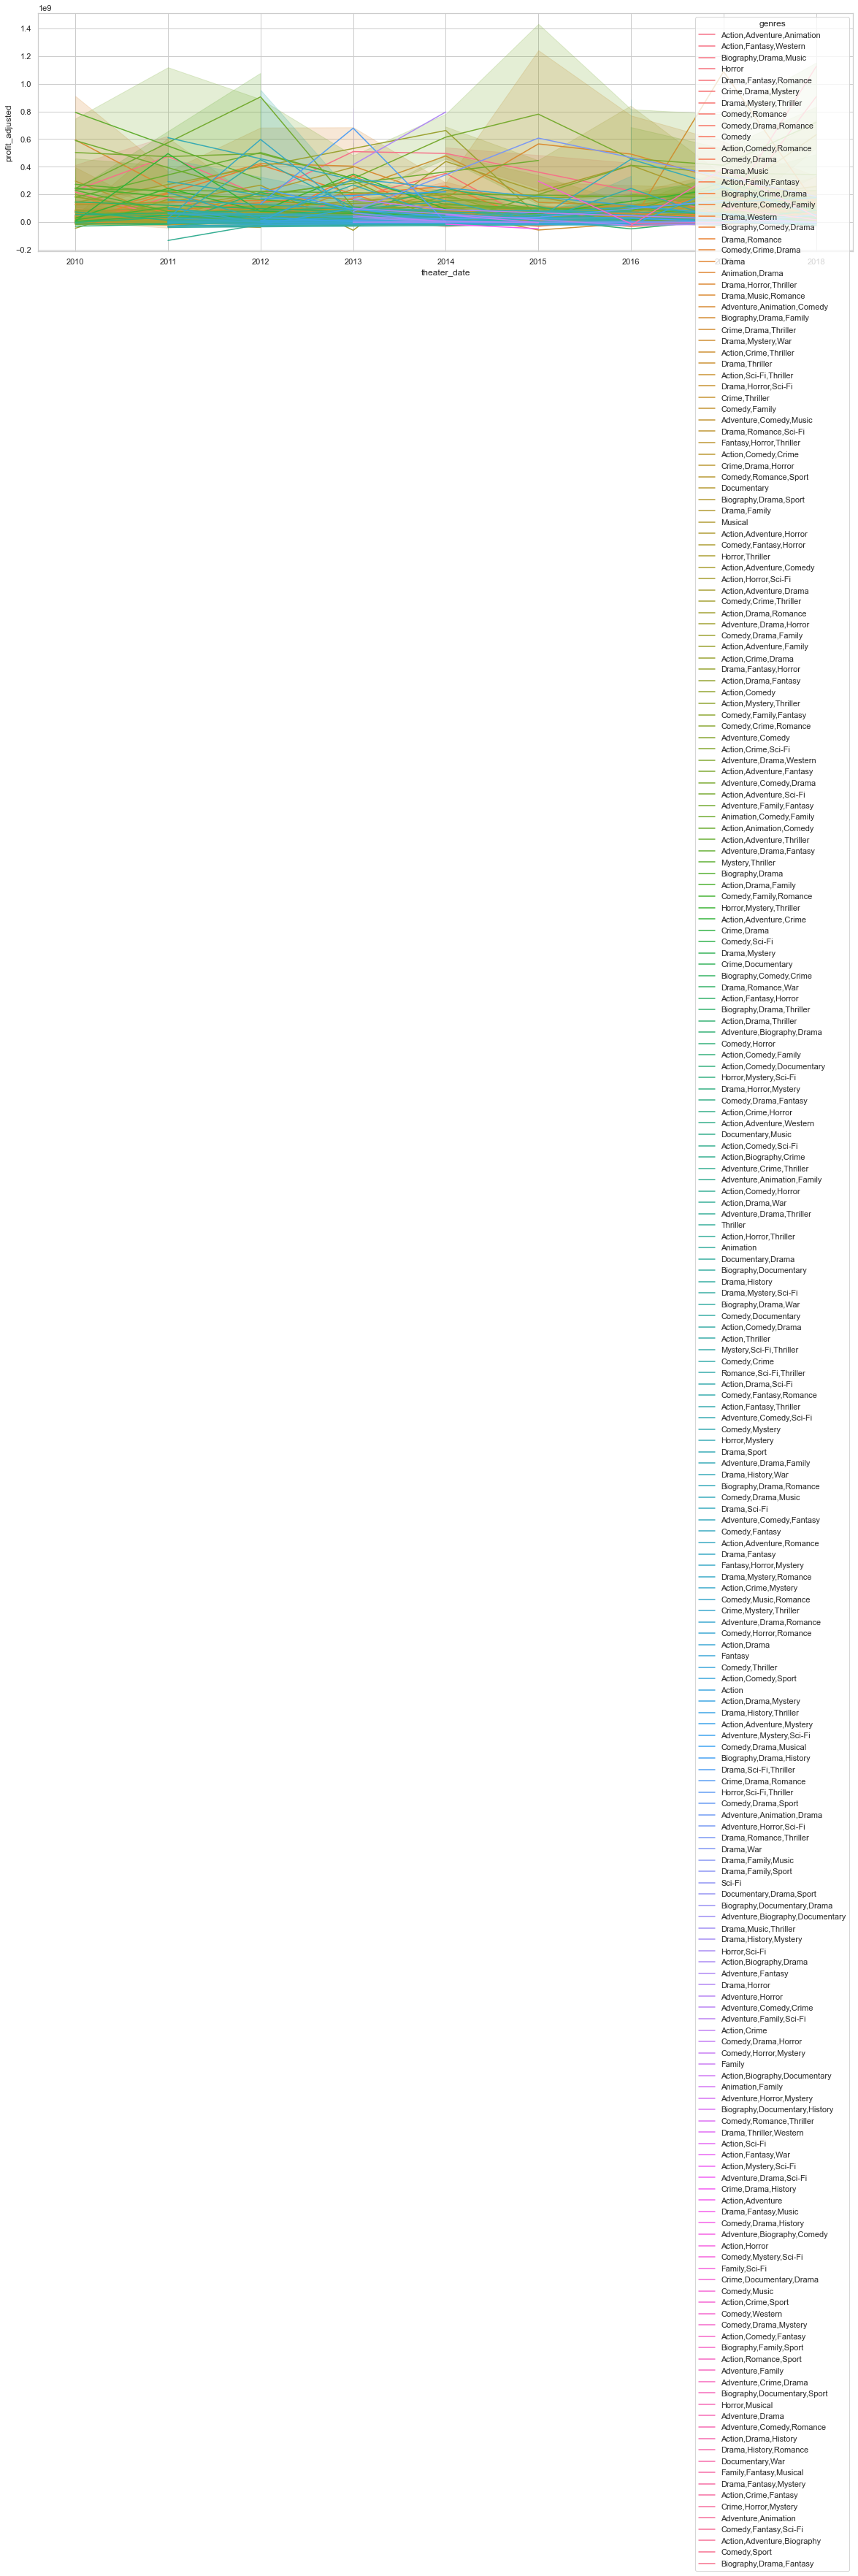

In [306]:
plt.figure(figsize=(20,6))
movies_gross = movies_gross.sort_values(by='theater_date')
sns.lineplot(x='theater_date', y='profit_adjusted', hue='genres', data=movies_gross)